# **HPGe Timing: extended data set (low energie range)**

In [1]:
# Check if there is GPU
import tensorflow as tf
from tensorflow.python.client.device_lib import list_local_devices
from tensorflow.config import list_physical_devices

# print(list_local_devices())
print("Num GPUs Available: ", len(list_physical_devices('GPU')))
list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

Scale features function

In [41]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler

scaler = None 

def scale_feature(feature, fit=False):
    global scaler
    # Reshape for normalizing relative to global max
    feature_serial = feature.reshape((feature.shape[0]*feature.shape[1],1))
    
    if fit: scaler = RobustScaler().fit(feature_serial)
        
    feature_serial = scaler.transform(feature_serial)
    feature_norm = feature_serial.reshape(feature.shape)
    
    return feature_norm

## Import libraries and data pre-processing

### Import libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import statistics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Conv1D, Flatten,MaxPooling1D, Reshape, UpSampling1D, Conv2DTranspose
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.utils import plot_model  # for plotting the model structure
from sklearn.preprocessing import StandardScaler 
#import np_utils

import h5py

import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

%matplotlib notebook
%matplotlib inline

## Autoencoder model

### Define model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Conv1D ,MaxPooling1D, AveragePooling1D, UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Input  
from tensorflow.nn import selu
import tensorflow as tf

# Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [7]:
length = 300  # signal lenght
kern_siz = 7  # semms to the best value, for all laters
n_filt = 20  # worse with n_filt~15, also no sense to icnrease

kernel_init =initializer = tf.keras.initializers.HeNormal()  # tf.keras.initializers.GlorotNormal(seed=9)


def encoder_def(nDimInput=length):
    enc_in = Input(shape=(300,), name="original_sign")
    resh = Reshape(target_shape=(300,1))(enc_in)
    cnv1 = Conv1D(filters=n_filt, kernel_size=kern_siz, padding='same', activation='relu', kernel_initializer=kernel_init)(resh)
    avg1 = AveragePooling1D(pool_size=3)(cnv1)
    cnv2 = Conv1D(filters=n_filt, kernel_size=kern_siz, padding='same', activation='relu', kernel_initializer=kernel_init)(avg1)
    avg2 = AveragePooling1D(pool_size=2)(cnv2)
    cnv3 = Conv1D(filters=n_filt, kernel_size=kern_siz, padding='same', activation='relu', kernel_initializer=kernel_init)(avg2)
    cnv4 = Conv1D(filters=1, kernel_size=kern_siz, activation='relu', kernel_initializer=kernel_init,padding='same')(cnv3)
    flat = Flatten()(cnv4)
    
    model = Model(enc_in, flat, name="encoder")
    model.compile(optimizer='Adam', loss='mse')
    return model


def decoder_def(nDimOutput=length):
    dec_in = Input(shape=(50,), name="encoder_sign")
    resh = Reshape(target_shape=(50,1))(dec_in)
    cnT1 = Conv1DTranspose(filters=1, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(resh)
    cnT2 = Conv1DTranspose(filters=n_filt, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(cnT1)
    ups1 = UpSampling1D(2)(cnT2)
    cnT3 = Conv1DTranspose(filters=n_filt, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(ups1)
    ups2 = UpSampling1D(3)(cnT3)
    cnT4 = Conv1DTranspose(filters=n_filt, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(ups2)
    cnT5 = Conv1DTranspose(filters=1, kernel_size=kern_siz, padding="same", kernel_initializer=kernel_init, activation="relu")(cnT4)
    dec_out = Flatten()(cnT5)
    
    model = Model(dec_in, dec_out, name="decoder")
    model.compile(optimizer='Adam', loss='mse')
    return model


def autoencoder_def(encoder, decoder):
    autoenc_input = Input(shape=(300,), name="sign")
    encoded_sign = encoder(autoenc_input)
    decoded_sign = decoder(encoded_sign)
    model = Model(autoenc_input, decoded_sign, name="autoencoder")
    model.compile(loss='mse', optimizer='adam', metrics=['mae']) 
    return model

In [8]:
encoder_model = encoder_def()
decoder_model = decoder_def()
autoencoder_model = autoencoder_def(encoder_model, decoder_model)

### Model summary

In [9]:
print (encoder_model.summary())

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_sign (InputLayer)   [(None, 300)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 300, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 20)           160       
_________________________________________________________________
average_pooling1d (AveragePo (None, 100, 20)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 20)           2820      
_________________________________________________________________
average_pooling1d_1 (Average (None, 50, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 20)            2820

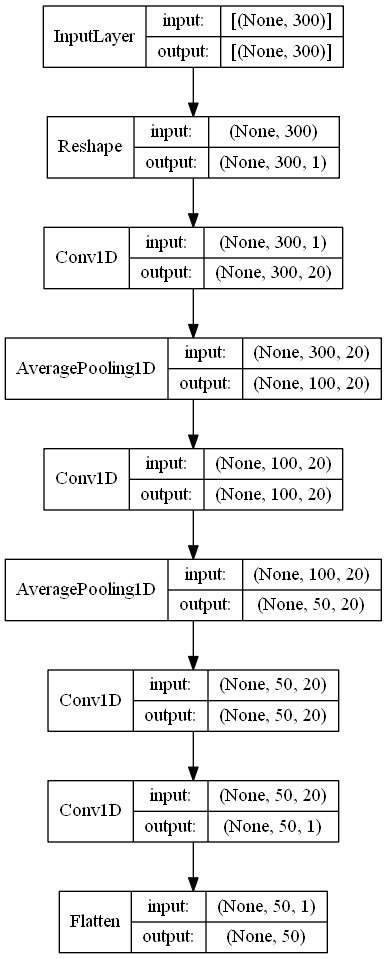

In [10]:
plot_model(encoder_model, show_shapes=True, show_layer_names=False)

**Decoder**

In [11]:
print (decoder_model.summary())

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_sign (InputLayer)    [(None, 50)]              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 50, 1)             8         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 50, 20)            160       
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 100, 20)           0         
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 100, 20)           2820      
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 300, 20)           0   

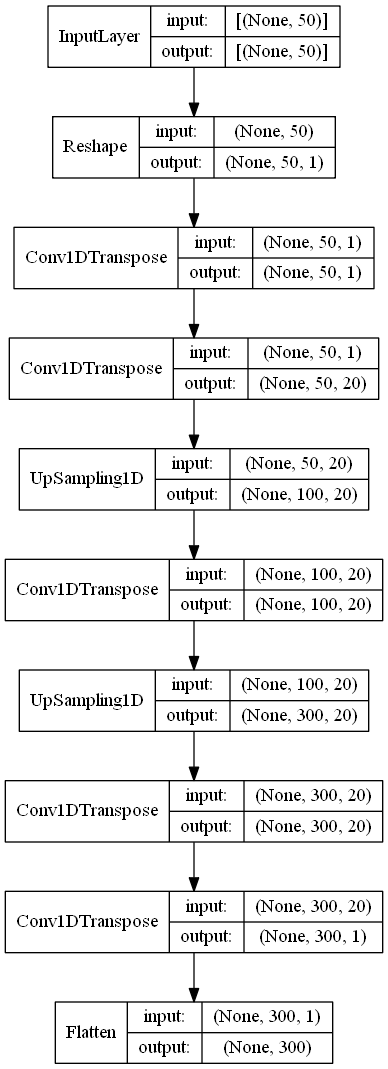

In [12]:
plot_model(decoder_model, show_shapes=True, show_layer_names=False)

**Autoencoder model**

In [13]:
print (autoencoder_model.summary())

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sign (InputLayer)            [(None, 300)]             0         
_________________________________________________________________
encoder (Functional)         (None, 50)                5941      
_________________________________________________________________
decoder (Functional)         (None, 300)               5949      
Total params: 11,890
Trainable params: 11,890
Non-trainable params: 0
_________________________________________________________________
None


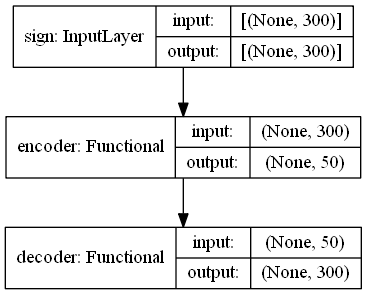

In [14]:
plot_model(autoencoder_model, show_shapes=True, show_layer_names=True)

Callback for train loss at the end of the each epoch

In [10]:
# Callback for train loss at the end of the each epoch
# from tensorflow.keras.callbacks import Callback

# class CallbackLoss(Callback):
#     def __init__(self, model, X_train, y_train, X_valid, y_valid, batch_size=32):
#       self.model = model
#       self.X_train = X_train
#       self.y_train = y_train
#       self.X_valid = X_valid
#       self.y_valid = y_valid
#       self.batch_size = batch_size
#       self.history = dict(loss=[], mae=[], val_loss=[], val_mae=[])
#       self.num = len(X_valid)


#     def on_epoch_end(self, epoch, logs=None):
#       eval_val = self.model.evaluate(self.X_train[:self.num], self.y_train[:self.num], batch_size=self.batch_size, verbose=0)
#       self.history["loss"].append(eval_val[0])
#       self.history["mae"].append(eval_val[-1])

#       eval_val = self.model.evaluate(self.X_valid, self.y_valid, batch_size=self.batch_size, verbose=0)
#       self.history["val_loss"].append(eval_val[0])
#       self.history["val_mae"].append(eval_val[-1])

#       print(f"\t\t\t\t\t Epoch's end: "
#             f"- loss: {self.history['loss'][-1]:.4e} "
#             f"- mae: {self.history['mae'][-1]:.4f} "
#             f"- val_loss: {self.history['val_loss'][-1]:.4e} "
#             f"- val_mae: {self.history['val_mae'][-1]:.4f}")



---


## Determing time t0

### Define model

In [15]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D, LSTM, Dropout

kernel_init = tf.keras.initializers.HeNormal()

def define_DetTime():
    # More Dense + Dropout
    detT_in = Input(shape=(50,), name="encoded_sign")
    den1 = Dense(128, activation='relu', kernel_initializer=kernel_init)(detT_in)
    den2 = Dense(64, activation='relu', kernel_initializer=kernel_init)(den1)
    detT_out = Dense(1, activation='relu', kernel_initializer=kernel_init)(den2)
    
    model = Model(detT_in, detT_out, name = "detTime")
    model.compile(loss='mse',optimizer='adam')
    return model

**Final Encoder-Determining time t0 NN**

*Encoder should be frozen, non trainable*

In [16]:
def define_EncDetTime(encoder, detTime):
    # freeze here already pre-traied Encoder
    encoder.trainable = False
    print(f"encoder trainable weights: {encoder.trainable_weights}")
    
    EncDetT_in = Input(shape=(300,), name="sign")
    encoded_sign = encoder(EncDetT_in)
    detT = detTime(encoded_sign)
    
    model = Model(EncDetT_in, detT, name="EncDetTime")
    model.compile(loss='mse',optimizer='adam', metrics=['mae'])
    return model

In [17]:
detTime_model = define_DetTime()
EncDetTime_model = define_EncDetTime(encoder_model, detTime_model)

encoder trainable weights: []


In [18]:
print (detTime_model.summary())

Model: "detTime"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoded_sign (InputLayer)    [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               6528      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 14,849
Trainable params: 14,849
Non-trainable params: 0
_________________________________________________________________
None


### Model summary

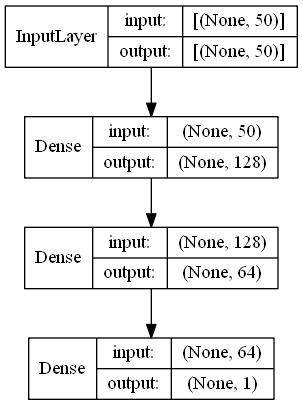

In [19]:
plot_model(detTime_model, show_shapes=True, show_layer_names=False)

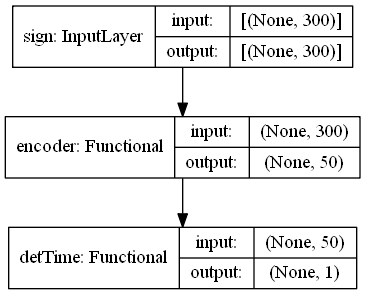

In [20]:
plot_model(EncDetTime_model, show_shapes=True)

In [21]:
print (EncDetTime_model.summary())

Model: "EncDetTime"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sign (InputLayer)            [(None, 300)]             0         
_________________________________________________________________
encoder (Functional)         (None, 50)                5941      
_________________________________________________________________
detTime (Functional)         (None, 1)                 14849     
Total params: 20,790
Trainable params: 14,849
Non-trainable params: 5,941
_________________________________________________________________
None




---


# All channels (100% of the data)



---


## Waveform training set


Read data

In [144]:
eLow=500 # kEV
eHigh=1000
t0max=280
# t0offset=130 #shift t0 close to the onset of the waveform, don`t know if it matters

length=300

channels = [4,5,6,7,8,9,10]
data = {}
for ch in channels:
    data[ch]={}
    
data[4]["name"]="Ge2"
data[5]["name"]="Ge3"
data[6]["name"]="Ge4"
data[7]["name"]="Ge5"
data[8]["name"]="Ge6"
data[9]["name"]="Ge7"
data[10]["name"]="Ge8"
#data[11]["name"]="Ge9"
#data[12]["name"]="Ge10"

Read data from .h5

In [145]:
hf = h5py.File('data/HPGe_data_Low_En_Cut.h5', 'r')

print(list(hf.keys()))
total_entries = 0

for ch in channels:
  group = hf.get(f"Ge{ch}")

  data[ch]["energy"] = np.array(group.get("energy"))
  data[ch]["time0"] = np.array(group.get("time0"))
  data[ch]["time"] = np.array(group.get("time"))
  data[ch]["samples"] = np.array(group.get("samples"))
  total_entries += data[ch]["time0"].shape[0]
  
hf.close()

print(total_entries)

['Ge10', 'Ge4', 'Ge5', 'Ge6', 'Ge7', 'Ge8', 'Ge9']
723826


## Data prep

Original t0 spectrum (low energies: 500 - 100 kEv)

Ge2: mean=156.0936110777364 std=10.058085928597219 #:133168
Ge3: mean=146.35132452624046 std=8.362241926611798 #:129971
Ge4: mean=156.52039492297635 std=6.839590512928233 #:102501
Ge5: mean=nan std=nan #:0
Ge6: mean=157.58213160623788 std=7.589312728371484 #:102214
Ge7: mean=154.29876634626132 std=7.366841211382667 #:143152
Ge8: mean=158.72435738344265 std=8.28307676088742 #:112820


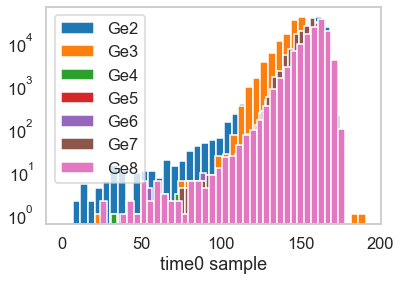

In [35]:
plt.grid()
for ch in channels:
    if ch != 10:
        #continue
        pass
    plt.hist(data[ch]["time0"],bins=36,label=data[ch]["name"])
    #plt.hist(data[ch]["time0"]+100,bins=36,label=data[ch]["name"])
    print(data[ch]["name"] + ": mean=" + str(np.mean(data[ch]["time0"])) + " std=" + str(np.std(data[ch]["time0"])) + " #:" + str(len(data[ch]["time0"])))
#plt.hist(data[8]["time0"],bins=40)
plt.xlabel("time0 sample")
plt.legend()
plt.yscale("log")
plt.show();

**Analize all channels**

In [146]:
for ch in channels:
    if ch == channels[0]:
        X = np.array(data[ch]["samples"])
        y = np.array(data[ch]["time0"])
        continue
    if ch == 7:  # channel 7 is empty
        continue
    X = np.concatenate((X,data[ch]["samples"]))
    y = np.concatenate((y,data[ch]["time0"]))
X.shape, y.shape

((723826, 300), (723826,))

**Delete data with wrong high t0 (can cause issues)**

In [38]:
# for i in range(len(y)-1, 0, -1):
#   if y[i] < 100:
#     #print(y[i])
#     y = np.delete(y, i)
#     X = np.delete(X, i, axis=0)

# X.shape, y.shape

## Data preprocessing

Dataset splitting:
* 64% - training, 16% - validation (model fit)
* 20% - test (model evaluation)

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(9)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

Scale features



In [148]:
X_train_scaled = scale_feature(X_train, fit=True)
X_test_scaled = scale_feature(X_test)
X_valid_scaled = scale_feature(X_valid)

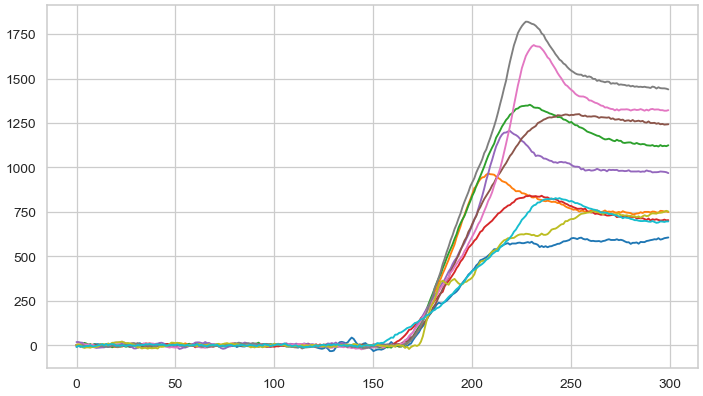

In [43]:
# Signal samples
fig = plt.figure(figsize=(14, 8),dpi= 60)
for x in X_train[:10]:
    plt.plot(x)

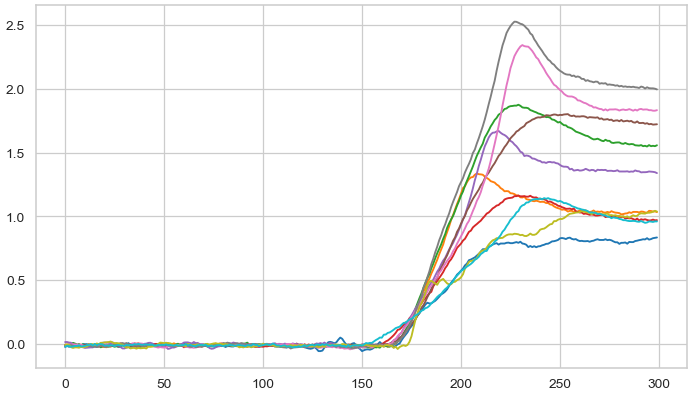

In [129]:
# Signal samples after scaling (RobustScaler)
fig = plt.figure(figsize=(14, 8),dpi= 60)
for x in X_train_scaled[:10]:
    plt.plot(x)

## Autoencoder

### Fit the model to the data

In [45]:
np.random.seed(9)
tf.random.set_seed(9)

encoder_model = encoder_def()
decoder_model = decoder_def()
autoencoder_model = autoencoder_def(encoder_model, decoder_model)
# print(f"encoder trainable weights: {encoder_model.trainable_weights}")

In [47]:
np.random.seed(9)
tf.random.set_seed(9)

batch_s = 256

early_stop = EarlyStopping(monitor='val_loss', patience=20)  # 20
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5, min_lr=0.25)
# callback_loss = CallbackLoss(autoencoder_model, X_train_norm, X_train_norm,
#                              X_valid_norm, X_valid_norm, batch_size=batch_s)

history = autoencoder_model.fit(X_train_scaled, X_train_scaled, batch_size=batch_s, epochs=1000, 
                                validation_data=(X_valid_scaled, X_valid_scaled), validation_batch_size=batch_s, 
                                callbacks=[early_stop])

Epoch 1/1000
1810/1810 [==============================] - 60s 23ms/step - loss: 0.0075 - mae: 0.0324 - val_loss: 3.8329e-04 - val_mae: 0.0148
Epoch 2/1000
1810/1810 [==============================] - 41s 22ms/step - loss: 5.0229e-04 - mae: 0.0168 - val_loss: 2.5992e-04 - val_mae: 0.0127
Epoch 3/1000
1810/1810 [==============================] - 41s 22ms/step - loss: 3.9198e-04 - mae: 0.0152 - val_loss: 2.2967e-04 - val_mae: 0.0120
Epoch 4/1000
1810/1810 [==============================] - 40s 22ms/step - loss: 3.3629e-04 - mae: 0.0142 - val_loss: 4.2565e-04 - val_mae: 0.0173
Epoch 5/1000
1810/1810 [==============================] - 41s 22ms/step - loss: 2.8516e-04 - mae: 0.0134 - val_loss: 2.0751e-04 - val_mae: 0.0115
Epoch 6/1000
1810/1810 [==============================] - 41s 23ms/step - loss: 2.6997e-04 - mae: 0.0129 - val_loss: 2.9365e-04 - val_mae: 0.0143
Epoch 7/1000
1810/1810 [==============================] - 41s 23ms/step - loss: 2.4012e-04 - mae: 0.0124 - val_loss: 1.9002e-04 

**Model history**

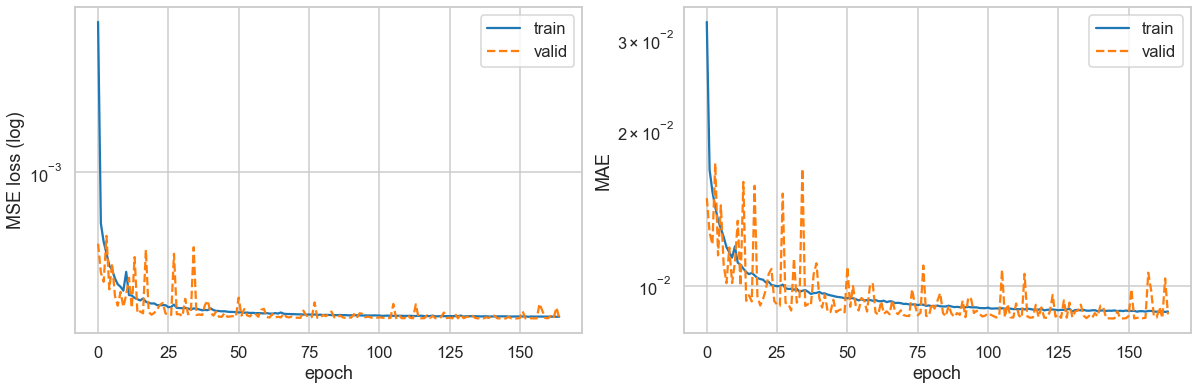

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# fig.suptitle(run_name, size=17)

ax1.set_yscale("log")
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'], '--')
ax1.set_ylabel('MSE loss (log)')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.set_yscale("log")
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'], '--')
ax2.set_ylabel('MAE')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'valid'], loc='upper right')

**Check autoencoder performance and signal residuals**

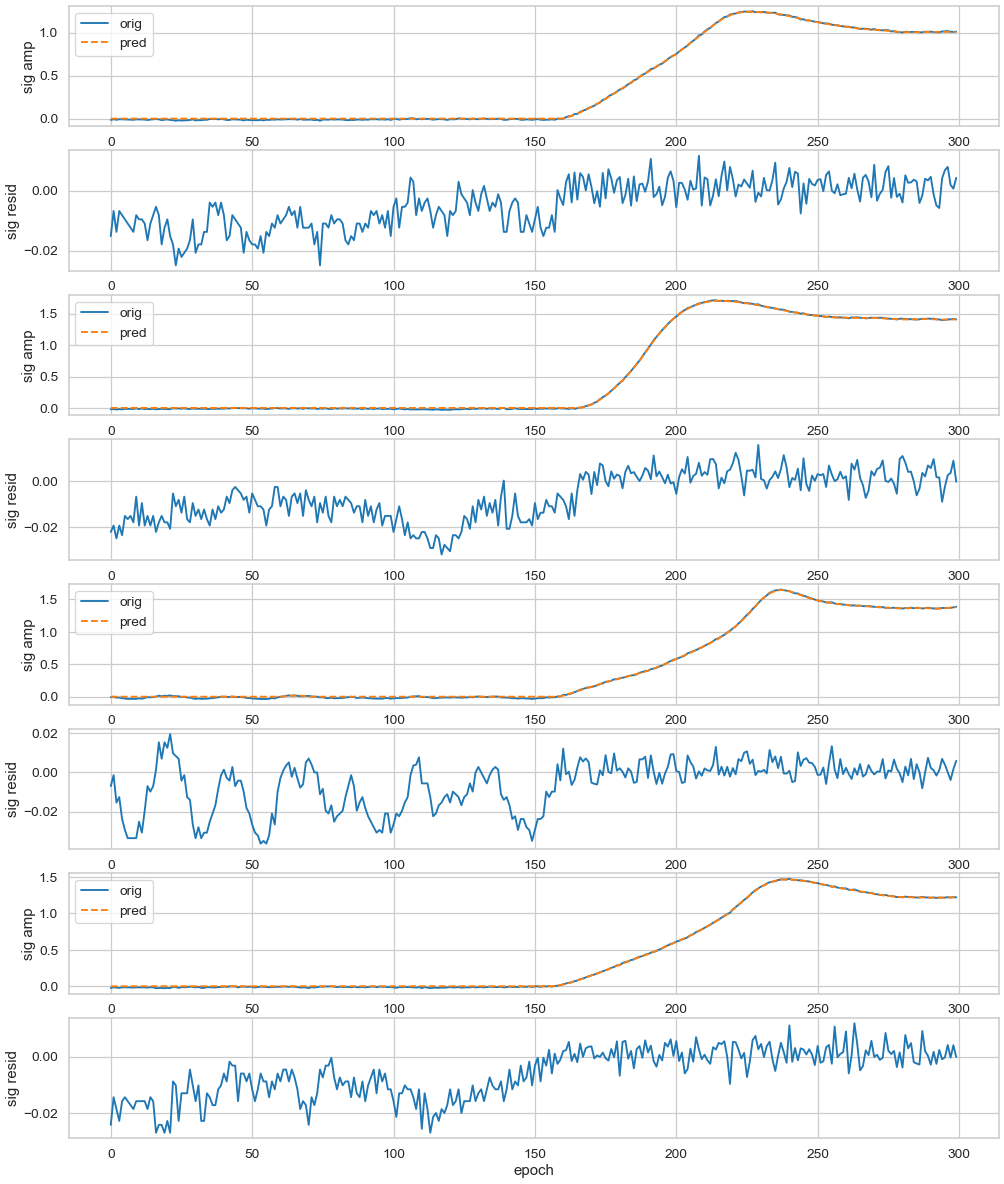

In [49]:
x=np.arange(300)
predictions = autoencoder_model.predict(X_test_scaled)#[0:100,:])
fig = plt.figure(figsize=(20, 25),dpi= 60)
#fig.subplots_adjust(hspace=0.01, wspace=0.02)
for i in range(8,16,2):
    ax = plt.subplot(8, 1, i+1-8)
    plt.plot(x,X_test_scaled[i,:])
    plt.plot(x,predictions[i,:], "--")
    ax.set_ylabel('sig amp')
    ax.set_xlabel('epoch')
    ax.legend(['orig', 'pred'], loc='upper left')
    
    res = X_test_scaled[i,:] - predictions[i,:]
    ax = plt.subplot(8, 1, i+2-8)
    plt.plot(x,res)
    ax.set_ylabel('sig resid')
    ax.set_xlabel('epoch')



---


## Determing time t0 (signal rising edge)

### Fit the model to the data

In [50]:
np.random.seed(9)
tf.random.set_seed(9)

detTime_model = define_DetTime()
EncDetTime_model = define_EncDetTime(encoder_model, detTime_model)

encoder trainable weights: []


In [51]:
np.random.seed(9)
tf.random.set_seed(9)

early_stop = EarlyStopping(monitor='val_loss', patience=10)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=5, min_lr=0.25)

# callback_loss = 0
# callback_loss = CallbackLoss(EncDetTime_model, X_train_scaled, y_train,
#                              X_valid_scaled, y_valid, batch_size=256)

history = EncDetTime_model.fit(X_train_scaled, y_train, batch_size=256, epochs=1000,
                               validation_data=(X_valid_scaled, y_valid), validation_batch_size=256,
                               callbacks=[early_stop])

Epoch 1/1000
1810/1810 [==============================] - 38s 20ms/step - loss: 410.6875 - mae: 8.1742 - val_loss: 31.3636 - val_mae: 4.0050
Epoch 2/1000
1810/1810 [==============================] - 35s 20ms/step - loss: 25.2722 - mae: 3.6306 - val_loss: 21.9718 - val_mae: 3.4781
Epoch 3/1000
1810/1810 [==============================] - 35s 20ms/step - loss: 20.9488 - mae: 3.3312 - val_loss: 19.5181 - val_mae: 3.1996
Epoch 4/1000
1810/1810 [==============================] - 37s 21ms/step - loss: 19.4905 - mae: 3.1976 - val_loss: 19.7614 - val_mae: 3.1291
Epoch 5/1000
1810/1810 [==============================] - 41s 23ms/step - loss: 18.5135 - mae: 3.1009 - val_loss: 17.9338 - val_mae: 2.9626
Epoch 6/1000
1810/1810 [==============================] - 36s 20ms/step - loss: 17.5918 - mae: 2.9861 - val_loss: 16.8081 - val_mae: 2.8358
Epoch 7/1000
1810/1810 [==============================] - 35s 20ms/step - loss: 16.8370 - mae: 2.8793 - val_loss: 16.1044 - val_mae: 2.7465
Epoch 8/1000
1810/1

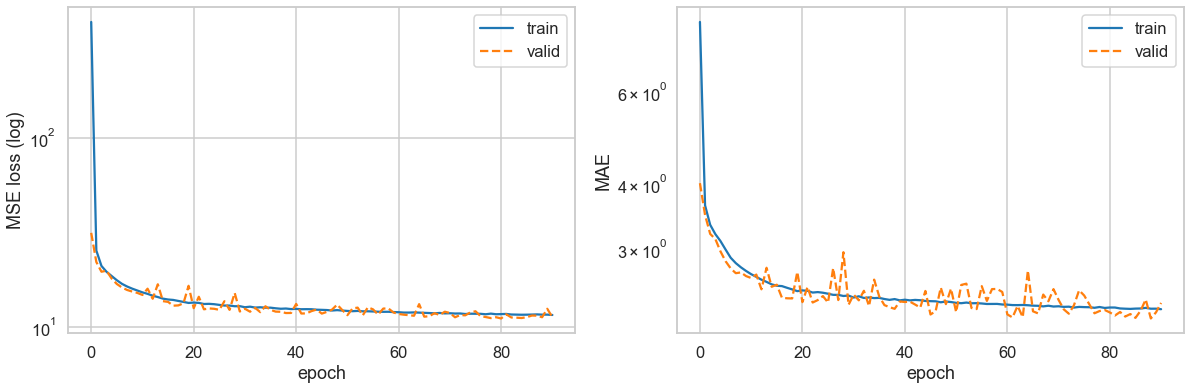

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
# fig.suptitle(run_name, size=17)

ax1.set_yscale("log")
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'], '--')
ax1.set_ylabel('MSE loss (log)')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.set_yscale("log")
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'], '--')
ax2.set_ylabel('MAE')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'valid'], loc='upper right')

### Checking the model

Jointplot: (t0_pred - t0) vs t0

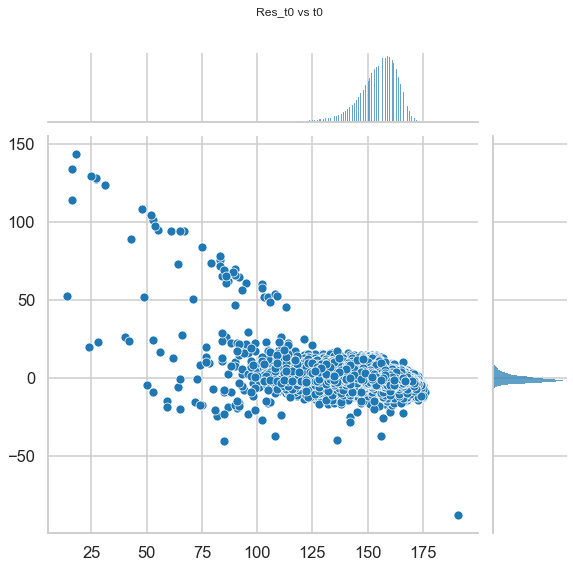

In [53]:
# scores = EncDetTime.evaluate(X_test_norm, y_test, verbose=0)
# print("%s: %.2f%%" % (modelEncodeDetTime.metrics_names[0], scores[0]))
predictionsT = EncDetTime_model.predict(X_test_scaled);
predictionsT = predictionsT.reshape(predictionsT.shape[0])
resT = predictionsT - y_test

resT.shape, predictionsT.shape, y_test.shape

p = sns.jointplot(x=y_test, y=resT, kind="scatter", height=8);
p.fig.suptitle("Res_t0 vs t0")
p.fig.subplots_adjust(top=0.9)

Jointplot: Predicted t0 vs original t0

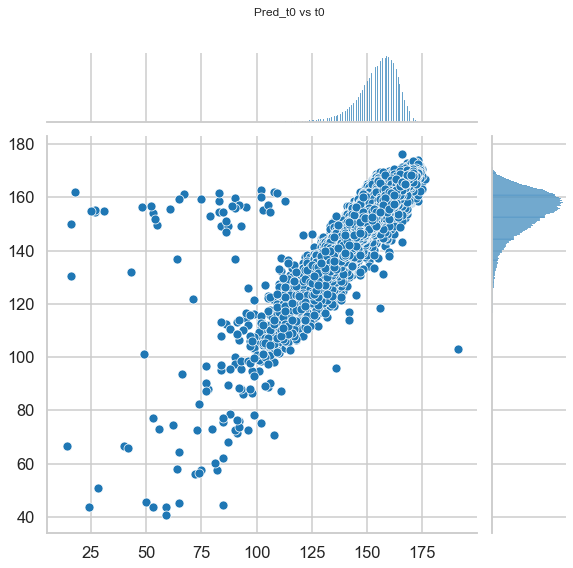

In [54]:
p = sns.jointplot(x=y_test, y=predictionsT, kind="scatter", height=8)
p.fig.suptitle("Pred_t0 vs t0")
p.fig.subplots_adjust(top=0.9)

**Autoencoder and DetTime performance**

158.91547
157.2885
147.38893
157.46805


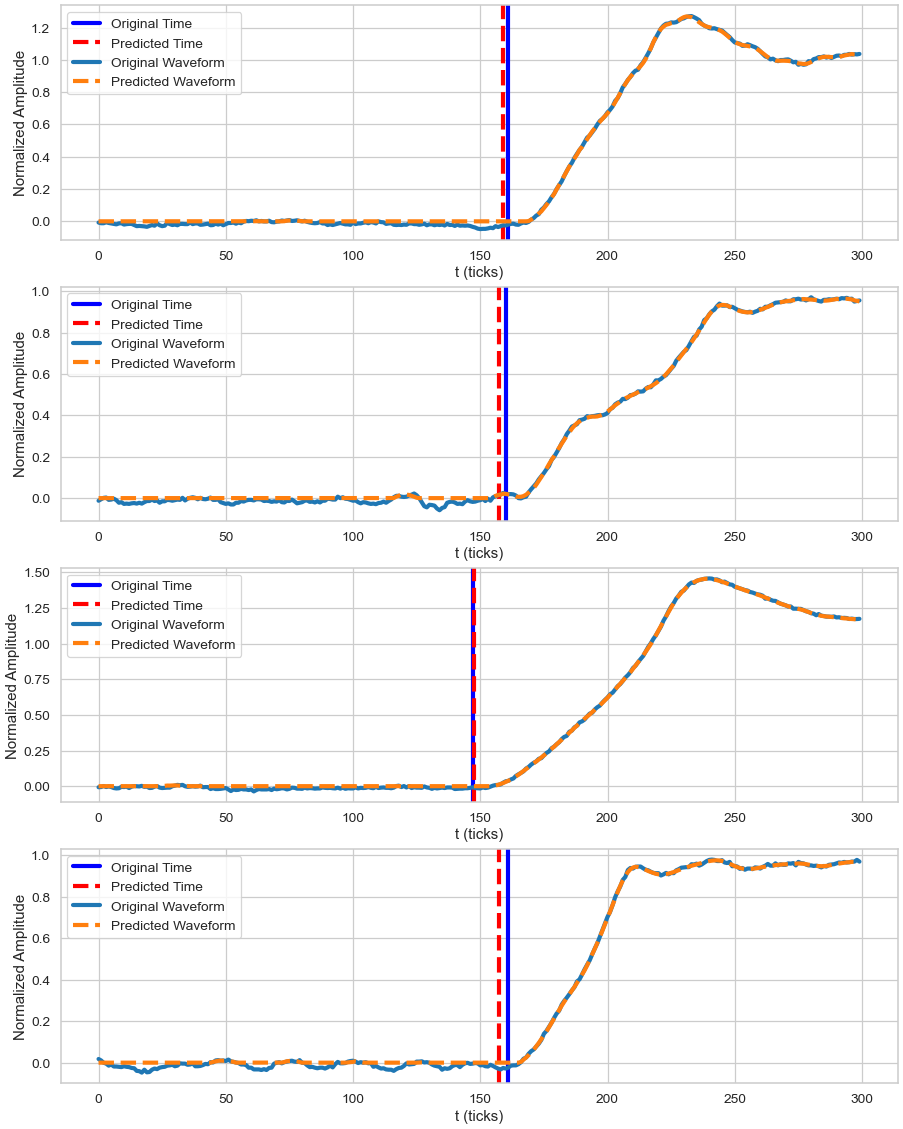

In [55]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
x = range(300)
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
fig = plt.figure(figsize=(18, 30),dpi= 60)
counter = 1
#fig.subplots_adjust(hspace=0.01, wspace=0.02)

# predictions = autoencoder_model.predict(X_test_norm)

for i in range(0,X_test_scaled.shape[0]):
    ax = plt.subplot(5, 1, counter)
    plt.axvline(y_test[i],color='b',linestyle='-', linewidth=5,label='Original Time')
    plt.axvline(predictionsT[i],color='r',linestyle='--', linewidth=5,label='Predicted Time')
    plt.plot(x,X_test_scaled[i,:],label='Original Waveform', linewidth=5,color='C0')
    plt.plot(x,predictions[i,:], linewidth=5, linestyle='--', label='Predicted Waveform',color='C1')
    
    print(predictionsT[i])
    #plt.legend(loc=' left')
    plt.legend()
    counter+=1
    plt.xlabel('t (ticks)')
    plt.ylabel('Normalized Amplitude')
    if(counter==5):
        break

#### Metrics

In [56]:
import sklearn.metrics as metrics

y = y_test
yhat = predictionsT

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.354980576445645
MSE: 11.514306991941039
RMSE: 3.393273786764198
R-Squared: 0.863038920402409


---

# Checking the trained EncDetTime model: 10188-10358_low_en dataset, W/O fitting the scaller

## Read data from .h5

In [149]:
channels = [4,5,6,8,9,10]
data = {}
for ch in channels:
    data[ch]={}
    
data[4]["name"]="Ge2"
data[5]["name"]="Ge3"
data[6]["name"]="Ge4"
# data[7]["name"]="Ge5"
data[8]["name"]="Ge6"
data[9]["name"]="Ge7"
data[10]["name"]="Ge8"
# data[11]["name"]="Ge9"
# data[12]["name"]="Ge10"

In [150]:
hf = h5py.File('data/HPGe_10188-10358_Low_En_Cut.h5', 'r')

print(list(hf.keys()))
total_entries = 0

for ch in channels:
  group = hf.get(f"Ge{ch}")

  data[ch]["energy"] = np.array(group.get("energy"))
  data[ch]["time0"] = np.array(group.get("time0"))
  data[ch]["time"] = np.array(group.get("time"))
  data[ch]["samples"] = np.array(group.get("samples"))
  total_entries += data[ch]["time0"].shape[0]
  
hf.close()

print(total_entries)

['Ge10', 'Ge4', 'Ge5', 'Ge6', 'Ge8', 'Ge9']
283512


Data prep

## Select the data

**Analize all channels**

In [151]:
for ch in channels:
    if ch == channels[0]:
        X_test_l = data[ch]["samples"]
        y_test_l = data[ch]["time0"]
        continue
    if ch == 7:
        continue
    X_test_l = np.concatenate((X_test_l,data[ch]["samples"]))
    y_test_l = np.concatenate((y_test_l,data[ch]["time0"]))
X_test_l.shape

(283512, 300)

## Scale features



In [152]:
for ch in channels:
    X_test_l_scaled = scale_feature(X_test_l)

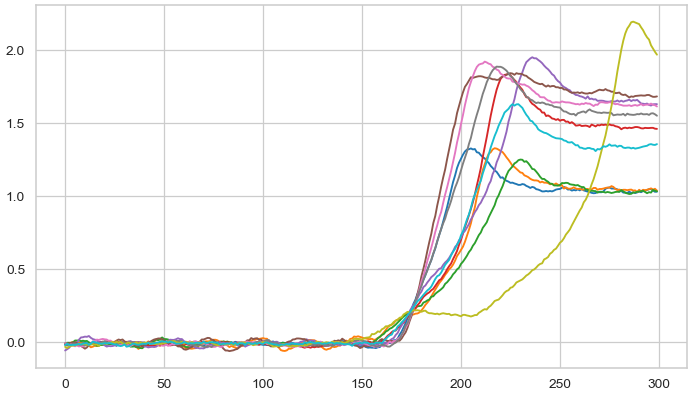

In [153]:
fig = plt.figure(figsize=(14, 8),dpi= 60)
for x in X_test_l_scaled[:10]:
    plt.plot(x)

## Checking the Autoencoder

**Check autoencoder performance and signal residuals**

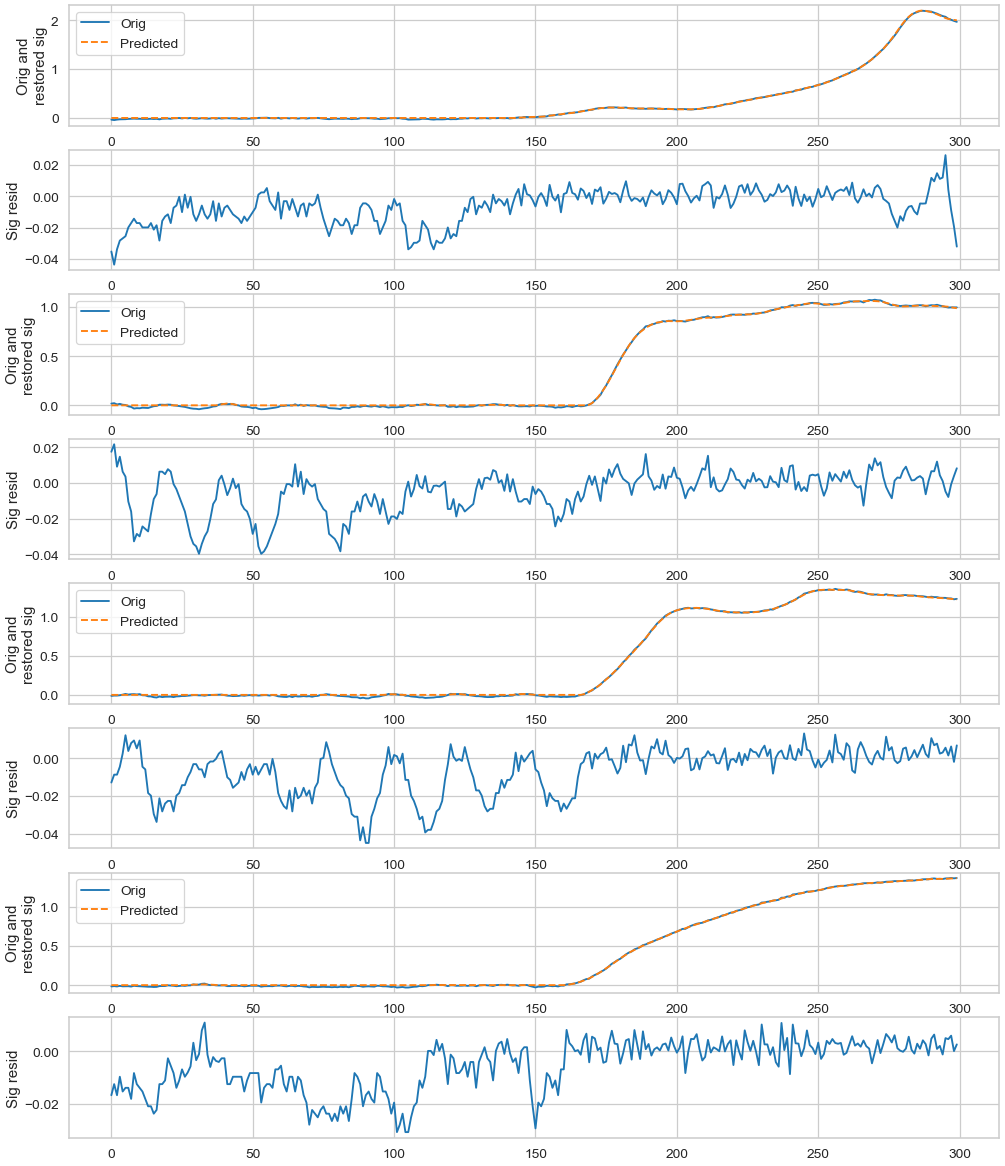

In [154]:
x=np.arange(300)
predictions_l = autoencoder_model.predict(X_test_l_scaled[0:100,:])#[0:100,:])
fig = plt.figure(figsize=(20, 25),dpi= 60)
#fig.subplots_adjust(hspace=0.01, wspace=0.02)
for i in range(8,16,2):
    ax = plt.subplot(8, 1, i+1-8)
    plt.ylabel('Orig and\nrestored sig')
    plt.plot(x,X_test_l_scaled[i,:])
    plt.plot(x,predictions_l[i,:], '--')
    plt.legend(['Orig', 'Predicted'], loc='upper left')
    res_l = X_test_l_scaled[i,:] - predictions_l[i,:]
    ax = plt.subplot(8, 1, i+2-8)
    plt.ylabel('Sig resid')
    plt.plot(x,res_l)

## Checking the model

In [155]:
predictionsT_l = EncDetTime_model.predict(X_test_l_scaled)
predictionsT_l.shape

(283512, 1)

**Autoencoder and DetTime performance**

[158.4621]
[133.8892]
[144.83992]
[150.46657]


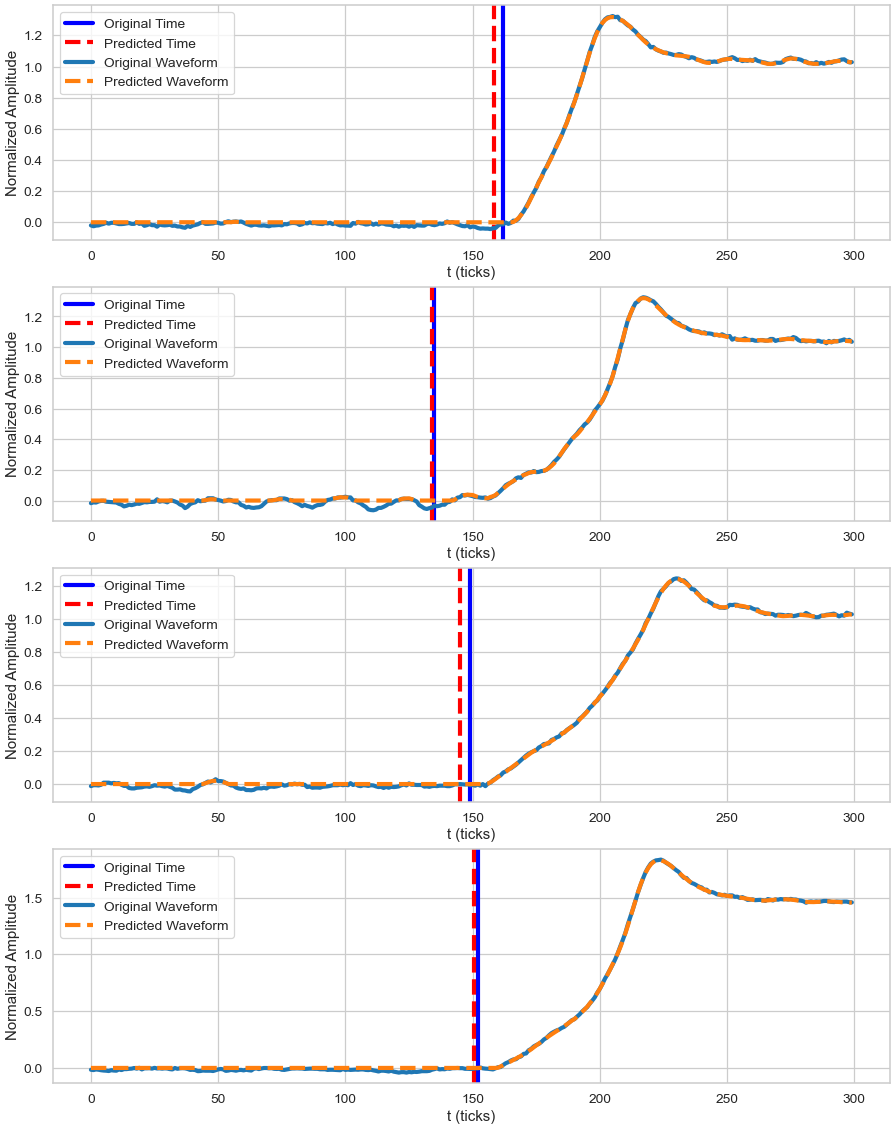

In [156]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
fig = plt.figure(figsize=(18, 30),dpi= 60)
counter=1
x = range(300)
#fig.subplots_adjust(hspace=0.01, wspace=0.02)
for i in range(0,X_test_l_scaled.shape[0]):
    ax = plt.subplot(5, 1, counter)
    plt.axvline(y_test_l[i],color='b',linestyle='-', linewidth=5,label='Original Time')
    plt.axvline(predictionsT_l[i],color='r',linestyle='--', linewidth=5,label='Predicted Time')
    plt.plot(x,X_test_l_scaled[i,:],label='Original Waveform', linewidth=5,color='C0')
    plt.plot(x,predictions_l[i,:],linestyle='--', linewidth=5,label='Predicted Waveform',color='C1')
    
    print(predictionsT_l[i])
    #plt.legend(loc=' left')
    plt.legend()
    counter+=1
    plt.xlabel('t (ticks)')
    plt.ylabel('Normalized Amplitude')
    if(counter==5):
        break

Jointplot: (t0_pred - t0) vs t0

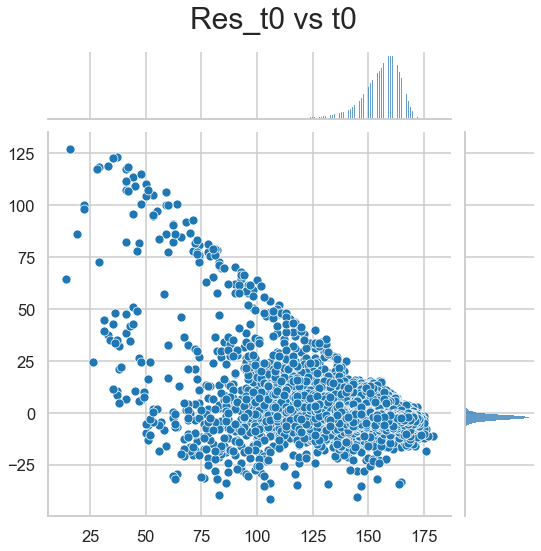

In [159]:
predictionsT_l.shape
predictionsT_l = predictionsT_l.reshape(predictionsT_l.shape[0])
resT_l = predictionsT_l - y_test_l


p = sns.jointplot(x=y_test_l, y=resT_l, kind="scatter", height=8);
p.fig.suptitle("Res_t0 vs t0")
p.fig.subplots_adjust(top=0.9)

#### Metrics

In [161]:
import sklearn.metrics as metrics

y = y_test_l
yhat = predictionsT_l

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.5964176759765865
MSE: 12.57420742485626
RMSE: 3.5460128912422553
R-Squared: 0.8545213196793375


# Checking the trained EncDetTime model: 10188-10358_low_en dataset

## Read data from .h5

In [183]:
channels = [4,5,6,8,9,10]
data = {}
for ch in channels:
    data[ch]={}
    
data[4]["name"]="Ge2"
data[5]["name"]="Ge3"
data[6]["name"]="Ge4"
# data[7]["name"]="Ge5"
data[8]["name"]="Ge6"
data[9]["name"]="Ge7"
data[10]["name"]="Ge8"
# data[11]["name"]="Ge9"
# data[12]["name"]="Ge10"

In [184]:
hf = h5py.File('data/HPGe_10188-10358_Low_En_Cut.h5', 'r')

print(list(hf.keys()))
total_entries = 0

for ch in channels:
  group = hf.get(f"Ge{ch}")

  data[ch]["energy"] = np.array(group.get("energy"))
  data[ch]["time0"] = np.array(group.get("time0"))
  data[ch]["time"] = np.array(group.get("time"))
  data[ch]["samples"] = np.array(group.get("samples"))
  total_entries += data[ch]["time0"].shape[0]
  
hf.close()

print(total_entries)

['Ge10', 'Ge4', 'Ge5', 'Ge6', 'Ge8', 'Ge9']
283512


Data prep

## Select the data

**Analize all channels**

In [185]:
for ch in channels:
    if ch == channels[0]:
        X_test_l = data[ch]["samples"]
        y_test_l = data[ch]["time0"]
        continue
    if ch == 7:
        continue
    X_test_l = np.concatenate((X_test_l,data[ch]["samples"]))
    y_test_l = np.concatenate((y_test_l,data[ch]["time0"]))
X_test_l.shape

(283512, 300)

## Scale features



In [186]:
for ch in channels:
    X_test_l_scaled = scale_feature(X_test_l, fit=True)

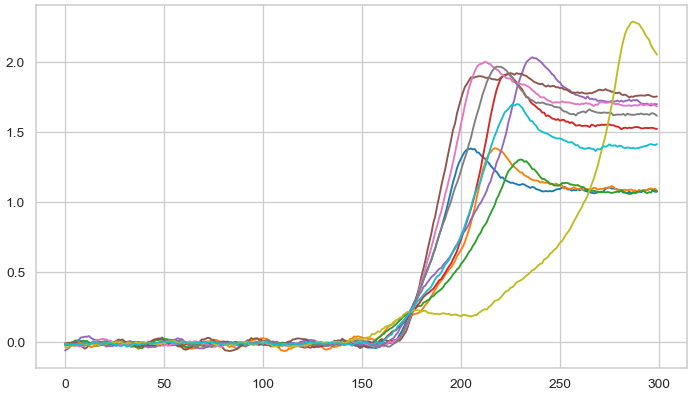

In [187]:
fig = plt.figure(figsize=(14, 8),dpi= 60)
for x in X_test_l_scaled[:10]:
    plt.plot(x)

## Checking the Autoencoder

**Check autoencoder performance and signal residuals**

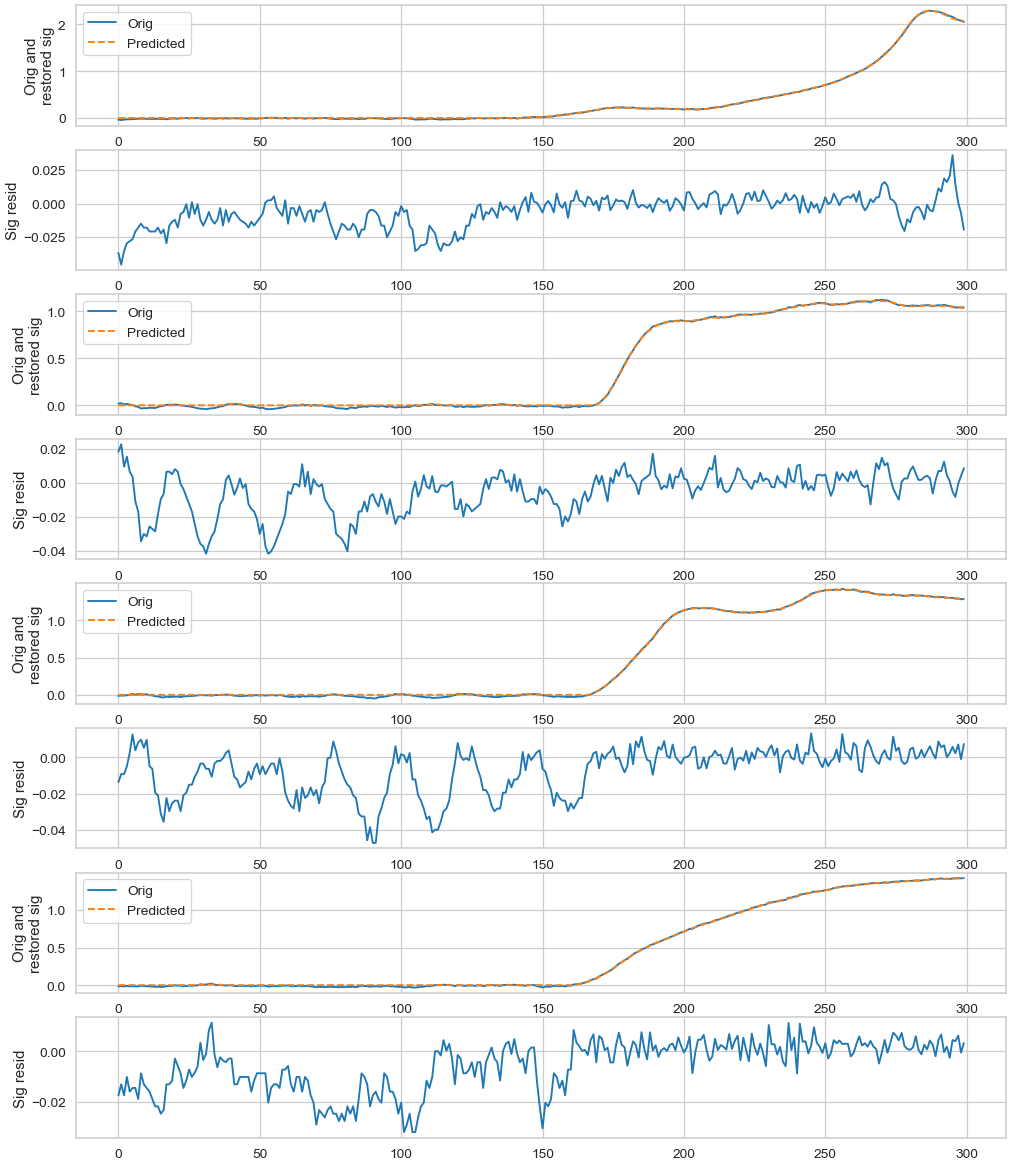

In [188]:
x=np.arange(300)
predictions_l = autoencoder_model.predict(X_test_l_scaled[0:100,:])#[0:100,:])
fig = plt.figure(figsize=(20, 25),dpi= 60)
#fig.subplots_adjust(hspace=0.01, wspace=0.02)
for i in range(8,16,2):
    ax = plt.subplot(8, 1, i+1-8)
    plt.ylabel('Orig and\nrestored sig')
    plt.plot(x,X_test_l_scaled[i,:])
    plt.plot(x,predictions_l[i,:], '--')
    plt.legend(['Orig', 'Predicted'], loc='upper left')
    res_l = X_test_l_scaled[i,:] - predictions_l[i,:]
    ax = plt.subplot(8, 1, i+2-8)
    plt.ylabel('Sig resid')
    plt.plot(x,res_l)

## Checking the model

In [189]:
predictionsT_l = EncDetTime_model.predict(X_test_l_scaled)
predictionsT_l.shape

(283512, 1)

**Autoencoder and DetTime performance**

[158.51715]
[133.58553]
[144.87547]
[150.62288]


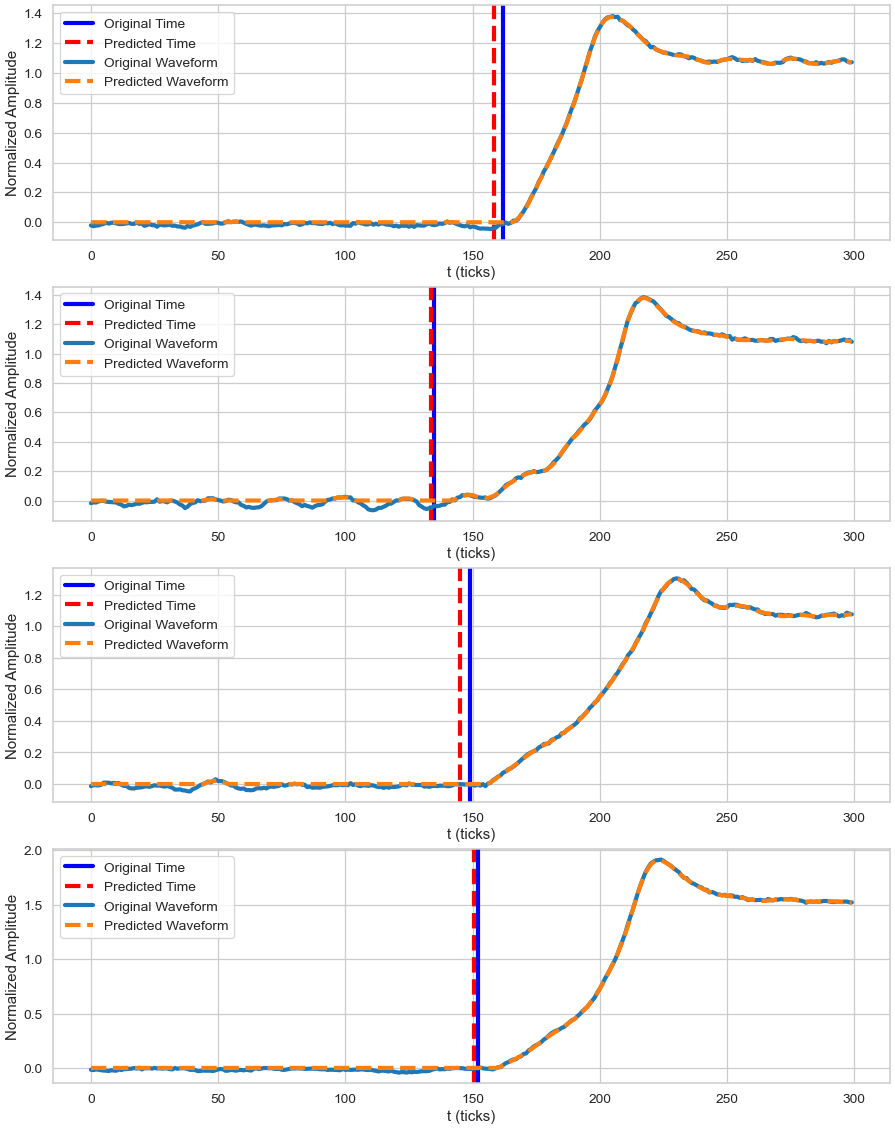

In [190]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
plt.rc('font', size=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
fig = plt.figure(figsize=(18, 30),dpi= 60)
counter=1
x = range(300)
#fig.subplots_adjust(hspace=0.01, wspace=0.02)
for i in range(0,X_test_l_scaled.shape[0]):
    ax = plt.subplot(5, 1, counter)
    plt.axvline(y_test_l[i],color='b',linestyle='-', linewidth=5,label='Original Time')
    plt.axvline(predictionsT_l[i],color='r',linestyle='--', linewidth=5,label='Predicted Time')
    plt.plot(x,X_test_l_scaled[i,:],label='Original Waveform', linewidth=5,color='C0')
    plt.plot(x,predictions_l[i,:],linestyle='--', linewidth=5,label='Predicted Waveform',color='C1')
    
    print(predictionsT_l[i])
    #plt.legend(loc=' left')
    plt.legend()
    counter+=1
    plt.xlabel('t (ticks)')
    plt.ylabel('Normalized Amplitude')
    if(counter==5):
        break

Jointplot: (t0_pred - t0) vs t0

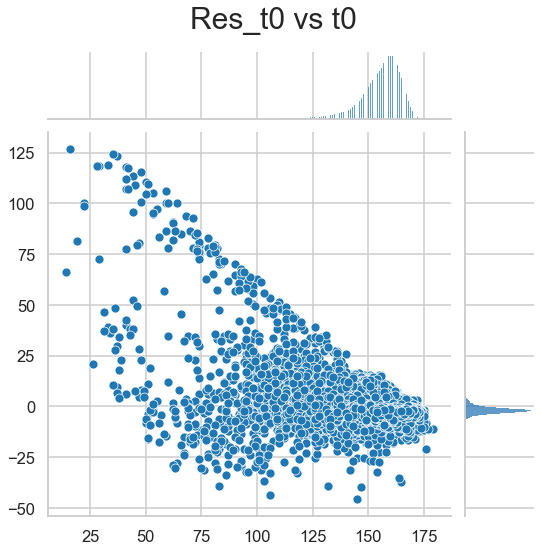

In [193]:
predictionsT_l.shape
predictionsT_l = predictionsT_l.reshape(predictionsT_l.shape[0])
resT_l = predictionsT_l - y_test_l


p = sns.jointplot(x=y_test_l, y=resT_l, kind="scatter", height=8);
p.fig.suptitle("Res_t0 vs t0")
p.fig.subplots_adjust(top=0.9)

#### Metrics

In [195]:
import sklearn.metrics as metrics

y = y_test_l
yhat = predictionsT_l

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 2.4518733128336394
MSE: 12.022302841409712
RMSE: 3.4673192586506527
R-Squared: 0.860906640658218
